# Initial Data Cleanup

This notebook performs a step-by-step data cleanup of the initial dataset. Below is a concise summary of the key operations:

- Define datasets for major inhibitory checkpoints: PD-1, PD-L1, CTLA-4, KIR, LAG3, TIM3.
- Perform resolution quality filtering.
- Calculate descriptive summary statistics of dataset

## Import Statements

In [5]:
import numpy as numpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'
os.makedirs('plots/data_cleanup')

In [2]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]


combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

/var/folders/53/7nzjfc950dz9z0q174xdmhj00000gn/T/ipykernel_17742/253701080.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=resolutions, palette='viridis')


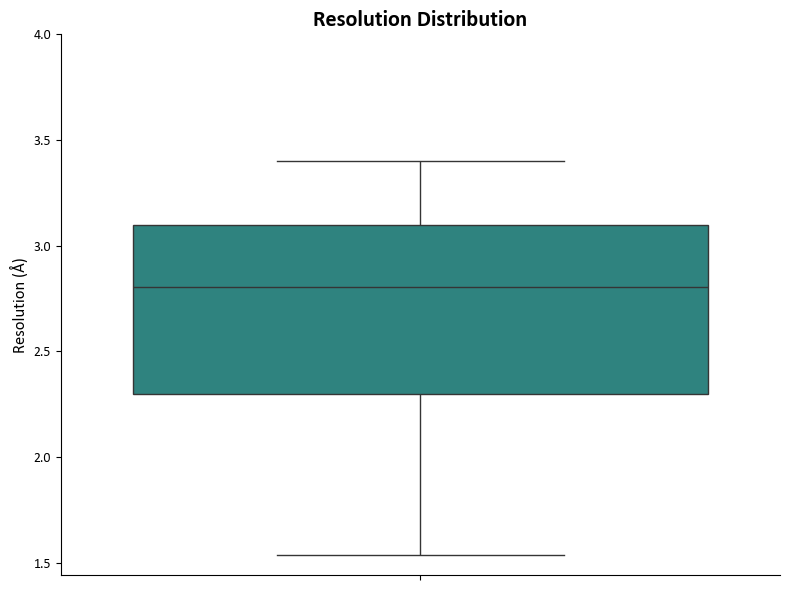

In [ ]:
resolutions = shuffled_df['resolution']

# Set figure size
plt.figure(figsize=(8, 6))

# Create the boxplot
sns.boxplot(data=resolutions, palette='viridis')
plt.ylim(top=4.0)

# Add title and labels
plt.title('Resolution Distribution', fontsize=16)
plt.ylabel('Resolution (Å)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Optional: remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()

plt.savefig('plots/data_cleanup/resolution_distribution_before_cleanup.pdf', bbox_inches='tight')
# plt.show()

## Sort antibodies to the checkpoints they bind to

In [8]:
l = ['CTLA-4', 'TIM3', 'PD-1', 'PD-L1', 'KIR', 'LAG3']

new_df = pd.DataFrame(index = l)

for item in l:
    count = shuffled_df[shuffled_df['compound'].str.contains(item, na=False)].shape[0]
    new_df.loc[item, 'count'] = count

new_df = new_df.reset_index()
new_df.columns = ['checkpoint', 'count'] 


# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab = shuffled_df_ab.dropna()

/var/folders/53/7nzjfc950dz9z0q174xdmhj00000gn/T/ipykernel_17742/867813981.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/53/7nzjfc950dz9z0q174xdmhj00000gn/T/ipykernel_17742/867813981.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


In [9]:
ab_checkpoint_clean = pd.DataFrame(index = shuffled_df_ab['checkpoint'].unique(), columns = ['antibody'])

for checkpoint in ab_checkpoint_clean.index:
    antibodies = shuffled_df_ab[shuffled_df_ab['checkpoint'] == checkpoint]['antibody'].unique()
    if len(antibodies) > 0:
        ab_checkpoint_clean.loc[checkpoint, 'antibody'] = ', '.join(sorted(antibodies))

with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    print(ab_checkpoint_clean)

                                                                                          antibody
PD-1     CAMRELIZUMAB, CEMIPLIMAB, DOSTARLIMAB, NIVOLUMAB, PEMBROLIZUMAB, SASANLIMAB, TISLELIZUMAB
TIM3                                                                                         M6903
PD-L1                                                           ATEZOLIZUMAB, AVELUMAB, DURVALUMAB
CTLA-4                                                                    IPILIMUMAB, TREMELIMUMAB
KIR2DL3                                                                                  LIRILUMAB


/var/folders/53/7nzjfc950dz9z0q174xdmhj00000gn/T/ipykernel_17742/2340843373.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=new_df, x='checkpoint', y='count', palette=viridis_hex)


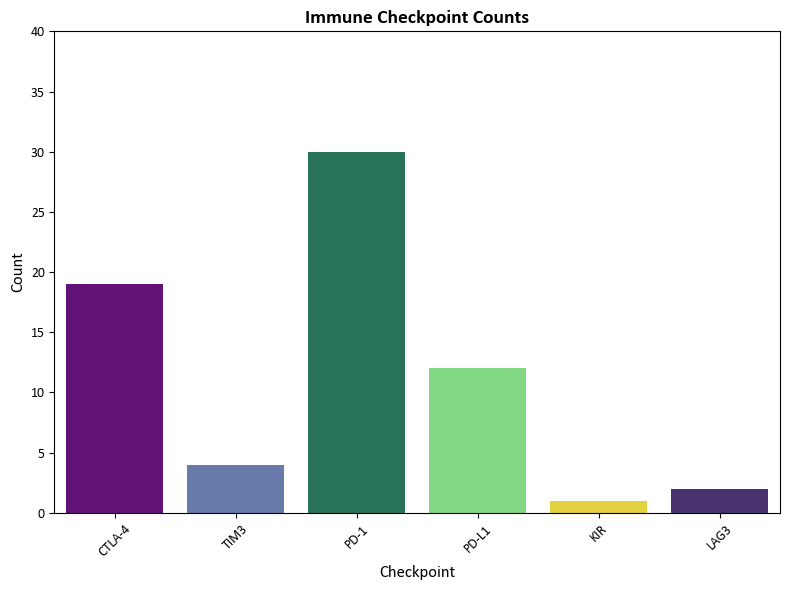

In [ ]:
plt.figure(figsize=(8, 6))

viridis_hex = [
    "#6D0387",  # dark purple
    "#5c75b4",  # blue
    "#1c7f5b",  # teal
    "#74e678",  # green
    "#fde725",  # yellow
    "#482878"   # violet-blue
]
sns.barplot(data=new_df, x='checkpoint', y='count', palette=viridis_hex)

# Styling
plt.title('Immune Checkpoint Counts', fontsize=14)
plt.xlabel('Checkpoint', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(top=40)
plt.tight_layout()
plt.savefig('plots/data_cleanup/immune_checkpoint_counts_before_cleanup.pdf', bbox_inches='tight')
plt.show()

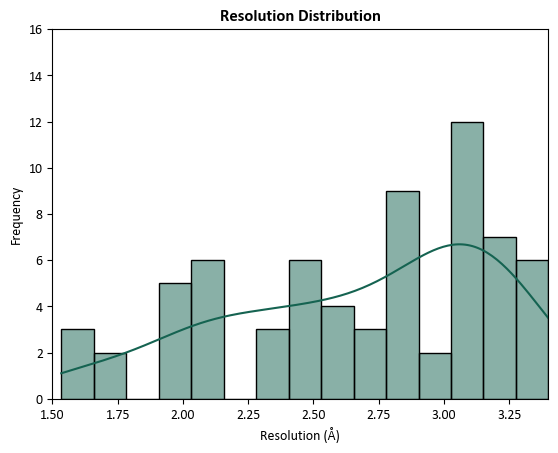

In [13]:
sns.histplot(shuffled_df['resolution'], bins=15, kde=True, color="#156351")
plt.title('Resolution Distribution')
plt.xlabel('Resolution (Å)')
plt.ylabel('Frequency')
plt.ylim(top = 16)
plt.xlim(left = 1.5, right = 3.4)

plt.savefig('plots/data_cleanup/resolution_distribution_histogram_after_cleanup.pdf', bbox_inches = 'tight')